In [1]:
# %load_ext autoreload
# %autoreload 2
import xarray as xr
import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import numpy as np
import warnings
import util
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta

from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

run="dpscream_rce_large_3km_lsascent300k_branch"
run_dir="/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/"
file=run_dir+f"{run}/run/{run}.eam.h1.2000-02-20-10800.nc"
print(file)
if run.split("_")[-2]=="lsascent":
    run_name = "lsascent304k"
else:
    run_name = run.split("_")[-1]
run_color=util.get_run_color(run_name)
print(run_color, run_name)

# for temp drift:
ndays=5
plt.rcParams['font.size']=18

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_lsascent300k_branch/run/dpscream_rce_large_3km_lsascent300k_branch.eam.h1.2000-02-20-10800.nc
tab:blue branch


# temperature drift

In [ ]:
ds = xr.open_dataset(file.replace("h1","h0"), chunks={'time':24*ndays,'lev':64,'ncol':2000})[["T","Z3"]]
t_init = ds['T'].isel(time=0).mean(dim=['ncol'])
z_init = ds.Z3.isel(time=0).mean(dim=['ncol'])/1000
t_end = ds['T'].isel(time=slice(-ndays*4,-1)).mean(dim=['ncol','time'])
z_end = ds.Z3.isel(time=-1).mean(dim=['ncol'])/1000
t_drift = t_end-t_init

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,8))
print("t_init...")
ax.plot(t_init, z_init, label="initial temp", color="lightskyblue")
print("t_end...")
ax.plot(t_end, z_end, label=f"last {ndays} days", color="b")
print("t_drift...")
axt = ax.twiny()
axt.plot(t_drift, z_end, label="temp drift", color='gray',linestyle='--')
print("done")
ax.legend()
ax.set(ylim=[0,20], xlim=[185,301], xlabel="Temperature (K)", ylabel="Height (km)")
axt.set(ylim=[0,20], xlim=[-5,5], xlabel="Temperature drift (K)")
axt.axvline(0,0,20,color='k',lw=0.5)
ax.grid(True)
plt.savefig(f"../plots/large/temp_drift_{run}_{ndays}.png")
plt.show()

# Temperature at the end of each simulation

In [4]:
runs = ["dpscream_rce_large_3km_default300k_branch",
        "dpscream_rce_large_3km_default304k_branch",
        "dpscream_rce_large_3km_lsascent300k_branch",
        "dpscream_rce_large_3km_lsascent304k_branch",
        "dpscream_rce_large_3km_lpfrz300k_branch",
        "dpscream_rce_large_3km_lpfrz304k_branch",
        "dpscream_rce_large_3km_lpls300k",
        "dpscream_rce_large_3km_lpls304k"]
colors = ["gray","tab:red","darkviolet","tab:purple","lightblue","tab:blue","gold","goldenrod"]


RUN: 0 default300k
RUN: 1 default304k
RUN: 2 lsascent300k
RUN: 3 lsascent304k
RUN: 4 lpfrz300k
RUN: 5 lpfrz304k
RUN: 6 lpls300k
RUN: 7 lpls304k
saved as all


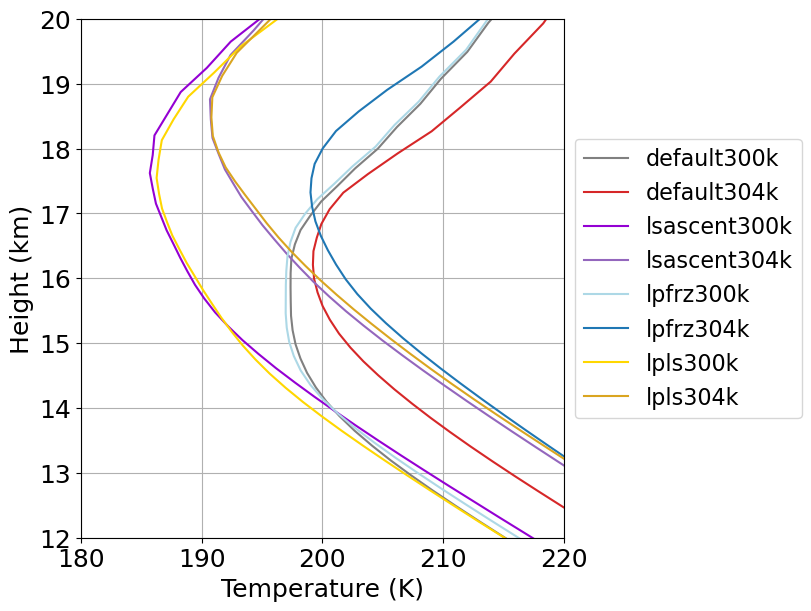

In [15]:
fig, ax1 = plt.subplots(1,1, figsize=(8,6), layout='constrained')
savename="all"
ndays=5
for i,run in enumerate(runs):
    if run.split("_")[-1] == "branch":
        lab = run.split("_")[-2]
    else:
        lab = run.split("_")[-1]
    print("RUN:", i, lab)
    file = run_dir+f"{run}/run/{run}_h0_last5days.nc"
    zfile = run_dir+f"{run}/run/{run}_Z3_mean.nc"
    ta = xr.open_dataset(file)["T"].isel(time=slice(-ndays*4,-1)).mean(dim=['ncol','time'])
    z = xr.open_dataset(zfile).Z3.isel(time=0).isel(x=0).isel(y=0)
    z = z/1000
    ax1.plot(ta, z, label=lab, color=colors[i])
ax1.grid()
ax1.set(
        ylim=[12,20],
        # ylim=[0,20],
        xlim=[180,220],
        xlabel="Temperature (K)", ylabel="Height (km)")
ax1.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=16)
plt.savefig(f"../plots/large/temp_profile_{savename}_last{ndays}days_utls.pdf")
print('saved as',savename)
plt.show()

# OLR and PW var over time - movie

In [2]:
run.split("_")[-1]

'branch'

In [3]:
ds = xr.open_dataset(file, chunks={'time':200,'ncol':2000})
ndays = int((ds.time[-1]-ds.time[0]).values/1e9/3600/24) # for branch
print(ds.time[0].values, ds.time[1].values, len(ds.time),"nsteps and ", ndays,"days")
olr = ds.FLUT
pw = ds.TMQ
pw_anom = pw - pw.mean(dim=['ncol'])
pw_var = pw_anom.var(dim=['ncol']).values
x = ds.crm_grid_x/1000
y = ds.crm_grid_y/1000
days = np.linspace(50,50+ndays,len(ds.time))
print(x.shape, olr.shape, days.shape)
del ds, pw, pw_anom

2000-02-20 01:00:00 2000-02-20 02:00:00 240 nsteps and  9 days
[########################################] | 100% Completed | 8.41 ss
(240, 147456) (240, 147456) (240,)


### Movie snapshots:

In [5]:
cmapr="cividis_r"

# do it only 60 at a time to not go over the memory limit
for t in range(0,10*24,3):  # range(len(olr.time)-2):
    print(t, end="... ")
    fig = plt.figure(figsize=plt.figaspect(0.3), layout='constrained')
    gs = GridSpec(2, 2, figure=fig, width_ratios=[100,4])
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[1,0])
    cax = fig.add_subplot(gs[0,1])
    im_olr = ax0.tripcolor(y[t,:], x[t,:], olr[t,:].T,
                           vmin=80, vmax=310, shading="gouraud", cmap=cmapr)
    ax0.set(xlabel="km",ylabel="km",title="OLR (W/m$^2$)",
            xlim=[0,5120], ylim=[0,320])
    plt.colorbar(im_olr, label="W/m$^2$", cax=cax)
    ax1.plot(days[:t], pw_var[:t], 'k')
    ax1.set(xlim=[0,50],xlabel='days',
            ylim=[0,230],ylabel='PW var')
    savename=f"../plots/movie/large_default_branch/olr_pwvar_{t:04d}.png"
    plt.savefig(savename)
    print("saved as "+savename)
    plt.close()


[########################################] | 100% Completed | 113.06 ms
[########################################] | 100% Completed | 2.96 sms
[########################################] | 100% Completed | 6.38 sms
[########################################] | 100% Completed | 220.07 ms
[########################################] | 100% Completed | 215.52 ms
[########################################] | 100% Completed | 128.99 ms
saved as ../plots/movie/large_default_branch/olr_pwvar_0000.png
[########################################] | 100% Completed | 917.62 ms
[########################################] | 100% Completed | 225.08 ms
[########################################] | 100% Completed | 216.65 ms
[########################################] | 100% Completed | 219.83 ms
[########################################] | 100% Completed | 218.18 ms
[########################################] | 100% Completed | 128.60 ms
saved as ../plots/movie/large_default_branch/olr_pwvar_0003.png
[#########

# 2d vars over time

## radiation

In [2]:
runs = [["dpscream_rce_large_3km_aa_default","dpscream_rce_large_3km_default300k_branch"],
        ["dpscream_rce_large_3km_aa_304ksst","dpscream_rce_large_3km_default304k_branch"],
        ["dpscream_rce_large_3km_ab_lsascent", "dpscream_rce_large_3km_lsascent300k_branch"],
        ["dpscream_rce_large_3km_aa_lsascent_304ksst","dpscream_rce_large_3km_lsascent304k_branch"],
        ["dpscream_rce_large_3km_aa_lpfrz", "dpscream_rce_large_3km_lpfrz300k_branch"],
        ["dpscream_rce_large_3km_aa_lpfrz304k", "dpscream_rce_large_3km_lpfrz304k_branch"],
        ["dpscream_rce_large_3km_lpls300k", None],
        ["dpscream_rce_large_3km_lpls304k", None]
       ]
colors = ["gray","tab:red","darkviolet","tab:purple",
          "lightblue","tab:blue", "gold", "goldenrod"]

In [ ]:
var = "albedo"
ds_means = {}
days = {}
for i,run in enumerate(runs):
    if run[1] is not None:
        run_name = run[1].split("_")[-2]
    else:
        run_name = run[0][-8:]
    print("RUN:", i+1, run_name)
    if run[1] is None:
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc"]
    elif run[1].split("_")[-2][:3]=="def":
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-20-03600.nc"]
    elif run[1].split("_")[-2]=="lpfrz304k":
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-10-10800.nc"]
    else:
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-20-10800.nc"]
    if var=="FLUT":
        ds = xr.open_mfdataset(files, chunks={'time':200,'ncol':2000})[['time', 'FLUT']]
    elif var=="albedo":
        ds = xr.open_mfdataset(files, chunks={'time':200,'ncol':2000})[['time', 'FSUTOA', 'SOLIN']]
        alb = (ds.FSUTOA/ds.SOLIN).where((ds.time.dt.hour==12))
        ds = ds.assign({'albedo':alb})
    print(ds[var].shape, ds.time.shape)
    ndays = int((ds.time[-1]-ds.time[0]).values/1e9/3600/24)
    print(ds.time[0].values, ds.time[1].values, len(ds.time),"nsteps and ", ndays,"days")
    days[run_name] = np.linspace(0,ndays,len(ds.time))
    ds_means[run_name] = ds[var].mean(dim=['ncol']).compute()

RUN: 1 default300k
(1441, 147456) (1441,)
2000-01-01 00:00:00 2000-01-01 01:00:00 1441 nsteps and  60 days
[########################################] | 100% Completed | 97.98 s
RUN: 2 default304k
(1440, 147456) (1440,)
2000-01-01 00:00:00 2000-01-01 01:00:00 1440 nsteps and  59 days
[########################################] | 100% Completed | 101.46 s
RUN: 3 lsascent300k
(1281, 147456) (1281,)
2000-01-01 00:00:00 2000-01-01 01:00:00 1281 nsteps and  60 days
[########################################] | 100% Completed | 87.05 s
RUN: 4 lsascent304k
(1281, 147456) (1281,)
2000-01-01 00:00:00 2000-01-01 01:00:00 1281 nsteps and  60 days
[########################################] | 100% Completed | 86.70 s
RUN: 5 lpfrz300k
(1281, 147456) (1281,)
2000-01-01 00:00:00 2000-01-01 01:00:00 1281 nsteps and  60 days
[########################################] | 100% Completed | 80.06 s
RUN: 6 lpfrz304k
(1121, 147456) (1121,)
2000-01-01 00:00:00 2000-01-01 01:00:00 1121 nsteps and  60 days
[########

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5), layout="constrained")

for i, run in enumerate(runs):
    if run[1] is not None:
        run_name = run[1].split("_")[-2]
    else:
        run_name = run[0][-8:]
    print("RUN:", i+1, run_name)
    ax.plot(days[run_name], ds_means[run_name], color=colors[i], label=run_name)
ax.grid(True)
ax.set(xlabel="days", ylabel=var)
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.savefig(f"../plots/large/{var}_timeseries.pdf")
plt.show()

## PW variance time series

In [29]:
runs = [["dpscream_rce_large_3km_aa_default","dpscream_rce_large_3km_default300k_branch"],
        ["dpscream_rce_large_3km_aa_304ksst","dpscream_rce_large_3km_default304k_branch"],
        ["dpscream_rce_large_3km_ab_lsascent", "dpscream_rce_large_3km_lsascent300k_branch"],
        ["dpscream_rce_large_3km_aa_lsascent_304ksst","dpscream_rce_large_3km_lsascent304k_branch"],
        ["dpscream_rce_large_3km_aa_lpfrz", "dpscream_rce_large_3km_lpfrz300k_branch"],
        ["dpscream_rce_large_3km_aa_lpfrz304k", "dpscream_rce_large_3km_lpfrz304k_branch"],
        ["dpscream_rce_large_3km_lpls300k", None],
        ["dpscream_rce_large_3km_lpls304k", None]
       ]
colors = ["gray","tab:red","darkviolet","tab:purple",
          "lightblue","tab:blue", "gold", "goldenrod"]


In [30]:
s="dpscream_rce_large_3km_lpls300k"
s[-8:-4]

'lpls'

0 default300k
2000-01-01 00:00:00 2000-01-01 01:00:00 1441 nsteps and  60 days
960 40.0 False
mean PW... (1441,)
pw_var anom...
[########################################] | 100% Completed | 46.35 s
pw_var normalized...
[########################################] | 100% Completed | 8.23 sms
(1441,) (1441,)
[########################################] | 100% Completed | 5.40 sms
1 default304k
2000-01-01 00:00:00 2000-01-01 01:00:00 1440 nsteps and  59 days
976 40.016678248783876 False
mean PW... (1440,)
pw_var anom...
[########################################] | 100% Completed | 48.08 s
pw_var normalized...
[########################################] | 100% Completed | 8.42 ss
(1440,) (1440,)
[########################################] | 100% Completed | 13.65 ss
2 lsascent300k
2000-01-01 00:00:00 2000-01-01 01:00:00 1281 nsteps and  60 days
853 39.984375 False
mean PW... (1281,)
pw_var anom...
[########################################] | 100% Completed | 40.86 s
pw_var normalized...
[#######

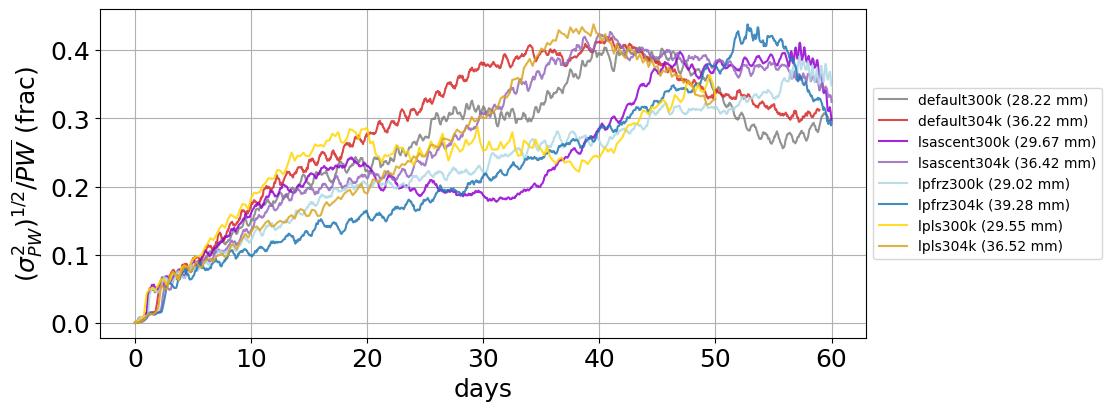

In [31]:
fig, ax1 = plt.subplots(1,1, figsize=(11,4), layout='constrained')
savename=""
for i,run in enumerate(runs):
    if run[1] is not None:
        print(i, run[1].split("_")[-2])
    else:
        print(i, run[0][-8:])
    ls='solid'
    if run[1] is None:
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc"]
    elif run[1].split("_")[-2][:3]=="def":
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-20-03600.nc"]
    elif run[1].split("_")[-2]=="lpfrz304k":
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-10-10800.nc"]
    else:
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-20-10800.nc"]
    ds = xr.open_mfdataset(files, chunks={'time':200,'ncol':2000})[['time','TMQ']]
                         # chunks={'time':200,'ncol':2000})
    ndays = int((ds.time[-1]-ds.time[0]).values/1e9/3600/24)
    print(ds.time[0].values, ds.time[1].values, len(ds.time),"nsteps and ", ndays,"days")
    days = np.linspace(0,ndays,len(ds.time))
    n40 = np.argmin(abs(days-40))
    print(n40, days[n40], days[n40]==30)
    pw_mean = ds.TMQ.mean(dim=['ncol'])
    print("mean PW...", pw_mean.shape)
    pw_var = ds.TMQ - pw_mean  # anom
    print("pw_var anom...")
    pw_var = np.sqrt(pw_var.var(dim=['ncol']).values)  # sum(anom**2)/len(anom)
    # pw_var = np.nansum(np.square(pw_var), axis=1)/pw_var.shape[1]
    pw_var = pw_var/pw_mean  # normalize over the mean (dimensionless)
    # pw_var = pw_var.std(dim=['ncol'])/pw_mean
    print("pw_var normalized...")
    pw_40day_mean = ds.TMQ[n40:].mean(dim=['ncol','time']).values
    # x = ds.crm_grid_x/1000
    # y = ds.crm_grid_y/1000
    print(pw_var.shape, days.shape)
    del ds
    if run[1] is not None:
        lab = run[1].split("_")[-2]
    else:
        lab = run[0][-8:]
    savename+="_"+lab
    ax1.plot(days, pw_var, c=colors[i], linestyle=ls,
             label=f"{lab} ({pw_40day_mean:.02f} mm)",
             alpha=0.85)
    ax1.set(xlabel='days',
            # ylim=[0,270],
            ylabel='$(\sigma^2_{PW})^{1/2}/\overline{PW}$ (frac)')
ax1.grid()
ax1.legend(loc="center left", fontsize=10, bbox_to_anchor=(1.,0.5))
# ax1.legend(loc=2, fontsize=10)
plt.savefig(f"../plots/large/PW_var{savename}_sqrtpwvar_norm.pdf",bbox_inches="tight", pad_inches=0.5)
print('saved as',savename)
plt.show()

## in-situ cloud fraction

we define in-situ as NUC < BCU, NUC < BCU-2, ...


### spatial plot

In [17]:
file = run_dir + run + f"/run/{run}.eam.h0.2000-01-01-00000.nc"
file2d = run_dir + run + f"/run/{run}.eam.h1.2000-01-01-00000.nc"
nuc_file = run_dir + run + f"/run/{run}_NUC_hrs.nc"
bcu_file = run_dir + run + f"/run/{run}_BCU_hrs.nc"
print(file)

ice = xr.open_dataset(file)[["IWC","T","crm_grid_x","crm_grid_y"]].isel(time=slice(-ndays*4,-1))
x = ice.crm_grid_x.isel(time=0)/1000
y = ice.crm_grid_y.isel(time=0)/1000
print(x.shape, y.shape)

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_aa_lpfrz304k/run/dpscream_rce_large_3km_aa_lpfrz304k.eam.h0.2000-01-01-00000.nc
(147456,) (147456,)


In [18]:
bcu = xr.open_dataset(bcu_file).BCU.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
# print(bcu.dims, bcu[1].time.values)
# tmp = np.where(np.nansum(np.where(bcu<2,1,0), axis=1)>=2,1,0)
# print(tmp.shape)
# bcu0 = np.mean(tmp, axis=0)
# bcu0.shape

In [19]:
nuc = xr.open_dataset(nuc_file).NUC.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
nuc = nuc.where((ice['T']<233.15)&(ice['IWC']>=1e-8))
nuc0 = np.mean(np.where(np.nansum(np.where(nuc<(bcu-5),1,0), axis=1)>=1,1,0), axis=0)
nuc0.shape

(147456,)

In [20]:
iwp = xr.open_dataset(file)["TGCLDIWP"].sel(time=ice.time, method="nearest")
iwp_plot = np.log10(iwp.mean(dim=["time"]))+3
iwp.shape, iwp_plot.shape

((19, 147456), (147456,))

In [21]:
# nuc0 = nuc0/(nuc.shape[0]*nuc.shape[2])
# bcu0 = bcu0/(nuc.shape[0]*nuc.shape[2])
# nuc0 = np.nanmean(np.where(nuc<bcu,1,0), axis=(0,1))
# bcu0 = np.nanmean(np.where(bcu<=0.125,1,0), axis=(0,1))
# print(nuc.shape, nuc0.shape, bcu0.shape)  # , nuc2.shape)

saved as ../plots/large/insitu_cirrus_frac_iwp_lpfrz304k_last5days.png


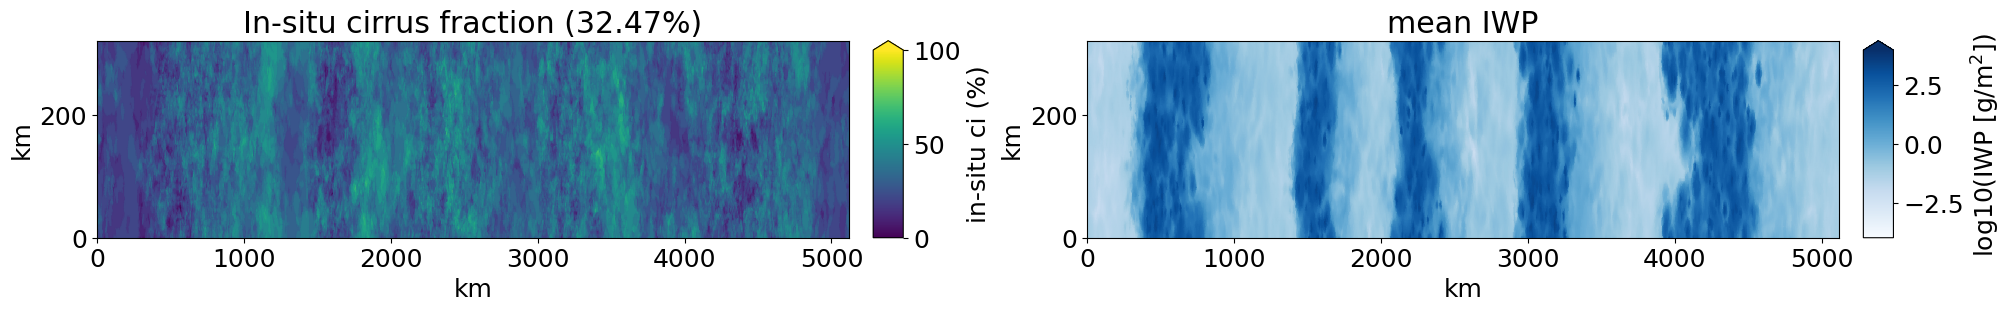

In [22]:
fig = plt.figure(figsize=(20,3), layout='constrained')
gs = GridSpec(1, 4, figure=fig, width_ratios=[100,4,100,4], hspace=0)
savename=""
if run.split("_")[-2]=="lsascent":
    lab = "lsascent304k"
else:
    lab=run.split("_")[-1]
savename+=lab

ax0 = fig.add_subplot(gs[0,0])
cax0 = fig.add_subplot(gs[0,1])
im = ax0.tripcolor(y, x, nuc0*100,
                   vmin=0, vmax=100,
                   shading="gouraud", cmap="viridis")
plt.colorbar(im, label="in-situ ci (%)", cax=cax0, shrink=0.8, extend='max')
ax1 = fig.add_subplot(gs[0,2])
cax1 = fig.add_subplot(gs[0,3])
im = ax1.tripcolor(y, x, iwp_plot,
                   vmin=-4, vmax=4,
                   shading="gouraud", cmap="Blues")
plt.colorbar(im, label="log10(IWP [g/m$^2$])", cax=cax1, shrink=0.8, extend='max')

ax0.set(ylabel="km", xlabel="km",
        xlim=[0,5120], ylim=[0,320])
ax1.set(xlabel="km",ylabel="km",
        xlim=[0,5120], ylim=[0,320])
ax0.set_title(f"In-situ cirrus fraction ({(np.nanmean(nuc0)*100):.02f}%)")
ax1.set_title("mean IWP")  # ({(np.nanmean(bcu0)*100):.02f}%)")
savename=f"../plots/large/insitu_cirrus_frac_iwp_{savename}_last{ndays}days.png"
plt.savefig(savename, dpi=150)
print("saved as "+savename)
plt.show()

### vertical plot

In [4]:
file = run_dir + run + f"/run/{run}.eam.h0.2000-01-01-00000.nc"
nuc_file = run_dir + run + f"/run/{run}_NUC_hrs.nc"
bcu_file = run_dir + run + f"/run/{run}_BCU_hrs.nc"
print(file)

ice = xr.open_dataset(file, chunks={'x':2000})[["IWC","T","Z3","crm_grid_x","crm_grid_y"]].isel(time=slice(-ndays*4,-1))
# z = xr.open_dataset(run_dir + run + f"/run/{run}_Zmean_last5days.nc").Z3[0,0,:,0]
# z = ice.Z3.mean(dim=['time','ncol'])/1000
# z = util.calc_theta(ice['T']).mean(dim=['time','ncol'])
z = ice['T'].mean(dim=['time','ncol'])
# trop_z = z.argmin(dim=['lev'])
print(z.shape)
print(ice.time[0].values, ice.time[-1].values)
nuc = xr.open_dataset(nuc_file).NUC.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
print(nuc.time[0].values, nuc.time[-1].values)
nuc = nuc.where((ice['T']<233.15)&(ice['IWC']>=1e-8))
bcu = xr.open_dataset(bcu_file).BCU.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
print(nuc.dims, bcu.dims, nuc[1].time.values, bcu[1].time.values)
# nuc0 = nuc.where(nuc<(bcu-5)).count(dim=['time','ncol'])
# bcu0 = bcu.where(bcu<2).count(dim=['time','ncol'])
# nuc0 = nuc0/(nuc.shape[0]*nuc.shape[-1])
# bcu0 = bcu0/(bcu.shape[0]*bcu.shape[-1])
nuc0 = np.nanmean(np.where(nuc<(bcu-5), 1, 0), axis=(0,2))
bcu0 = np.nanmean(np.where(bcu<2, 1, 0), axis=(0,2))
print("nuc0, bcu0 calculated", nuc0.shape, bcu0.shape)
# nuc0 = np.nanmean(np.where(nuc<bcu,1,0), axis=(0,2))
# bcu0 = np.nanmean(np.where(bcu<=0.125,1,0), axis=(0,2))
ci_cldcov = np.mean(np.where(np.nansum(np.where(nuc<(bcu-5),1,0), axis=1)>=1,1,0))
dc_cldcov = np.mean(np.where(np.nansum(np.where(bcu<2,1,0), axis=1)>=1,1,0))
print(nuc.shape, nuc0.shape, bcu0.shape)  # , nuc2.shape)


/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_aa_lsascent_304ksst/run/dpscream_rce_large_3km_aa_lsascent_304ksst.eam.h0.2000-01-01-00000.nc
(128,)
2000-02-15 06:00:00 2000-02-19 18:00:00
2000-02-15 06:00:00 2000-02-19 18:00:00
('time', 'lev', 'ncol') ('time', 'lev', 'ncol') 2000-02-15 12:00:00 2000-02-15 12:00:00
[########################################] | 100% Completed | 9.62 ss
[########################################] | 100% Completed | 9.72 s
nuc0, bcu0 calculated (128,) (128,)
[########################################] | 100% Completed | 10.04 s
[########################################] | 100% Completed | 10.04 s
(19, 128, 147456) (128,) (128,)


In [5]:
trop_z = np.argmin(z.values)

[########################################] | 100% Completed | 2.85 ss
[########################################] | 100% Completed | 2.85 s


In [6]:
nuc0.shape, z.shape, z[trop_z:].values

[########################################] | 100% Completed | 4.47 ss
[########################################] | 100% Completed | 4.48 s


((128,),
 (128,),
 array([190.63048, 191.07959, 191.58363, 192.28493, 193.01627, 193.89972,
        194.83374, 195.90143, 197.00298, 198.24918, 199.56952, 201.01692,
        202.48653, 204.05553, 205.68689, 207.41502, 209.14471, 210.92514,
        212.77573, 214.71002, 216.65582, 218.61049, 220.62943, 222.7226 ,
        224.83038, 226.92203, 229.04025, 231.20978, 233.39476, 235.5487 ,
        237.69498, 239.87271, 242.05258, 244.17496, 246.24352, 248.30548,
        250.33347, 252.27037, 254.09601, 255.86497, 257.61505, 259.33163,
        261.00723, 262.662  , 264.27505, 265.84625, 267.38712, 268.91525,
        270.4076 , 271.8641 , 273.29276, 274.8648 , 276.52853, 278.26605,
        280.0412 , 281.7686 , 283.38474, 284.87424, 286.26645, 287.58676,
        288.81335, 289.9059 , 290.87805, 291.75494, 292.53522, 293.19833,
        293.76074, 294.2653 , 294.71722, 295.0892 , 295.38135, 295.62387,
        295.84634, 296.0519 , 296.23804, 296.40457, 296.55136, 296.67477,
        296.7773 , 2

[########################################] | 100% Completed | 4.97 ss
[########################################] | 100% Completed | 4.98 s
[########################################] | 100% Completed | 5.69 ss
[########################################] | 100% Completed | 5.71 s
saved as ../plots/large/insitu_cirrus_dc_vertical_t_lsascent304k_last5days.png


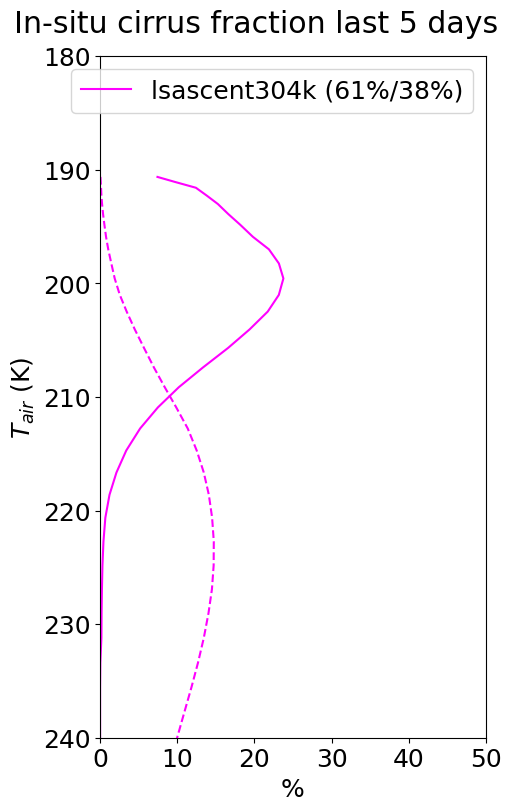

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5,8), layout='constrained')

ax.plot((nuc0*100)[trop_z:], z[trop_z:], color=run_color, 
        label=run_name+f" ({int(ci_cldcov*100)}%/{int(dc_cldcov*100)}%)")
ax.plot((bcu0*100)[trop_z:], z[trop_z:], color=run_color, linestyle="--")
ax.set(xlabel="%",
       # ylabel="km", 
       ylabel="$T_{air}$ (K)",
       xlim=[0,50],
       # ylim=[10,20]
       # ylim=[340,400]
       ylim=[240,180]
      )
fig.suptitle(f"In-situ cirrus fraction last {ndays} days")
ax.legend()
savename=f"../plots/large/insitu_cirrus_dc_vertical_t_{run_name}_last{ndays}days.png"
plt.savefig(savename, transparent=True)
print("saved as "+savename)
plt.show()

### timeseries

In [10]:
file = run_dir + run + f"/run/{run}.eam.h0.2000-01-01-00000.nc"
nuc_file = run_dir + run + f"/run/{run}_NUC_hrs.nc"
bcu_file = run_dir + run + f"/run/{run}_BCU_hrs.nc"
print(file)

chunks = {'time':100, 'ncol':16000, 'x':16000}

ice = xr.open_dataset(file, chunks=chunks)[["IWC","T","crm_grid_x","crm_grid_y"]]
x = ice.crm_grid_x.isel(time=0)/1000
y = ice.crm_grid_y.isel(time=0)/1000
print(x.shape, y.shape)

nuc = xr.open_dataset(nuc_file, chunks=chunks).NUC.rename({'x':'ncol'}) #.sel(time=ice.time, method="nearest")
nuc = nuc.where((ice['T']<233.15)&(ice['IWC']>=1e-8))
bcu = xr.open_dataset(bcu_file, chunks=chunks).BCU.rename({'x':'ncol'}) #  .sel(time=ice.time, method="nearest")
print(nuc.dims, bcu.dims, nuc[1].time.values, bcu[1].time.values)
nuc

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_aa_default/run/dpscream_rce_large_3km_aa_default.eam.h0.2000-01-01-00000.nc
(147456,) (147456,)
('time', 'lev', 'ncol') ('time', 'lev', 'ncol') 2000-01-01 06:00:00 2000-01-01 06:00:00


<xarray.DataArray 'NUC' (time: 201, lev: 128, ncol: 147456)> Size: 15GB
dask.array<where, shape=(201, 128, 147456), dtype=float32, chunksize=(100, 128, 16000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2kB 2000-01-01 00:00:00 ... 2000-02-20 00:00:00
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: ncol
Attributes:
    long_name:     Nucleation tracer
    units:         kg/kg
    mdims:         1
    mixing_ratio:  dry
    cell_methods:  time: point

In [11]:
nuc0 = nuc.where(nuc<bcu).count(dim=['lev','ncol'])
bcu0 = nuc.where(bcu<2).count(dim=['lev','ncol'])
nuc0

<xarray.DataArray 'NUC' (time: 201)> Size: 2kB
dask.array<sum-aggregate, shape=(201,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2kB 2000-01-01 00:00:00 ... 2000-02-20 00:00:00

In [12]:
nuc0 = nuc0/(nuc.shape[-1]*nuc.shape[1])
bcu0 = bcu0/(nuc.shape[-1]*nuc.shape[1])
# nuc0 = np.nanmean(np.where(nuc<bcu,1,0), axis=(0,1))
# bcu0 = np.nanmean(np.where(bcu<=0.125,1,0), axis=(0,1))
print(nuc.shape, nuc0.shape, bcu0.shape)  # , nuc2.shape)
nuc0

(201, 128, 147456) (201,) (201,)


<xarray.DataArray 'NUC' (time: 201)> Size: 2kB
dask.array<truediv, shape=(201,), dtype=float64, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2kB 2000-01-01 00:00:00 ... 2000-02-20 00:00:00

In [ ]:
nuc0.compute()
bcu0.compute()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,3), layout='constrained')

nuc0.plot(x='time', ax=ax, color='tab:red', label='NUC')
bcu0.plot(x='time', ax=ax, color='tab:blue', label='BCU')

ax.legend()
ax.grid(True)
plt.show()

[########################################] | 100% Completed | 33m 41s
[###############                         ] | 38% Completed | 439.67 s

### W_NUC and NI_NUC and NI for in-situ vs convective gridboxes

In [ ]:
file = run_dir + run + f"/run/{run}.eam.h0.2000-01-01-00000.nc"
var_name="NI_NUC"
nuc_file = run_dir + run + f"/run/{run}_NUC_hrs.nc"
bcu_file = run_dir + run + f"/run/{run}_BCU_hrs.nc"
var_file = run_dir + run + f"/run/{run}_{var_name}_hrs.nc"
qsmall=1e-8
print(var_name, file)

ice = xr.open_dataset(file, chunks={'x':2000})[["NUMICE","Q","IWC","T"]].isel(time=slice(-ndays*4,-1))
nuc = xr.open_dataset(nuc_file).NUC.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
bcu = xr.open_dataset(bcu_file).BCU.rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
if var_name!="NI":
    var = xr.open_dataset(var_file, chunks={'x':2000})[var_name].rename({'x':'ncol'}).sel(time=ice.time, method="nearest")
    var = var.where((ice['T']<233.15)&(ice['IWC']>qsmall))
print(nuc.dims, bcu.dims, nuc[1].time.values, bcu[1].time.values)
print(nuc.shape, bcu.shape)
# nuc = nuc.where(nuc<bcu).count(dim=['time','lev'])
# bcu = nuc.where(bcu<2).count(dim=['time','lev'])
if var_name=="NI_NUC":
    var = util.calc_ni(var, ice.Q, ice.lev, ice['T'])/1e6
elif var_name=="NI":
    var = util.calc_ni(ice.NUMICE, ice.Q, ice.lev, ice['T'])/1e6
print(var.shape)
var_insitu = var.where(nuc<bcu)
print(var_insitu.shape)
var_conv = var.where(bcu<2)
print(var_conv.shape)
print("done.")

In [ ]:
fig = plt.figure(figsize=(7,3))
if var_name=="W_NUC":
    var_conv.plot.hist(bins=[0,0.25,0.5,1,2,4,8,16], histtype='step',
                       label='convective', yscale='log', xscale='log', lw=2)
    var_insitu.plot.hist(bins=[0,0.25,0.5,1,2,4,8], histtype='step',
                         label='in-situ', yscale='log', xscale='log', lw=2)
    plt.xlabel("W_NUC (m/s)")
elif var_name=="NI_NUC":
    var_conv.plot.hist(bins=np.logspace(-6,0,30), histtype='step',
                       label='convective', yscale='log', xscale='log', lw=2)
    var_insitu.plot.hist(bins=np.logspace(-6,0,30), histtype='step',
                         label='in-situ', yscale='log', xscale='log', lw=2)
    plt.xlabel("calc ni NUC (#/cm3)")
elif var_name=="NI":
    var_conv.plot.hist(bins=np.logspace(-6,0,30), histtype='step',
                       label='convective', yscale='log', xscale='log', lw=2)
    var_insitu.plot.hist(bins=np.logspace(-6,0,30), histtype='step',
                         label='in-situ', yscale='log', xscale='log', lw=2)
    plt.xlabel("calc ni (#/cm3)")
plt.title(f"{var_name} {(run[-8:])}")  # ({(np.nanmean(var_insitu)):.02f}) m/s")
plt.legend(fontsize=12)
plt.savefig(f"../plots/large/hist_{var_name}_{run}.png")
print('saved')
plt.show()

## 2d vars snapshot - OLR and PW - all simulations

In [40]:
# runs = [["dpscream_rce_large_3km_aa_default","dpscream_rce_large_3km_default300k_branch"],
#         ["dpscream_rce_large_3km_ab_lsascent", "dpscream_rce_large_3km_lsascent300k_branch"],
#         ["dpscream_rce_large_3km_aa_lpfrz", "dpscream_rce_large_3km_lpfrz300k_branch"],
#         ["dpscream_rce_large_3km_lpls300k", None]]
runs = [["dpscream_rce_large_3km_aa_304ksst","dpscream_rce_large_3km_default304k_branch"],
        ["dpscream_rce_large_3km_aa_lsascent_304ksst","dpscream_rce_large_3km_lsascent304k_branch"],
        ["dpscream_rce_large_3km_aa_lpfrz304k", "dpscream_rce_large_3km_lpfrz304k_branch"],
        ["dpscream_rce_large_3km_lpls304k", None]]

In [41]:
ndays = 45
vars=["TMQ","FLUT","crm_grid_x","crm_grid_y"]

RUN: default304k starttime 2000-02-15 00:00:00
(147456,)
[########################################] | 100% Completed | 118.50 ms
[########################################] | 100% Completed | 126.85 ms
[########################################] | 100% Completed | 223.60 ms
[########################################] | 100% Completed | 104.45 ms
[########################################] | 100% Completed | 104.34 ms
[########################################] | 100% Completed | 103.14 ms
[########################################] | 100% Completed | 102.77 ms
[########################################] | 100% Completed | 116.55 ms
[########################################] | 100% Completed | 104.94 ms
[########################################] | 100% Completed | 107.12 ms
[########################################] | 100% Completed | 104.57 ms
[########################################] | 100% Completed | 103.45 ms
RUN: lsascent304k starttime 2000-02-15 00:00:00
(147456,)
[####################

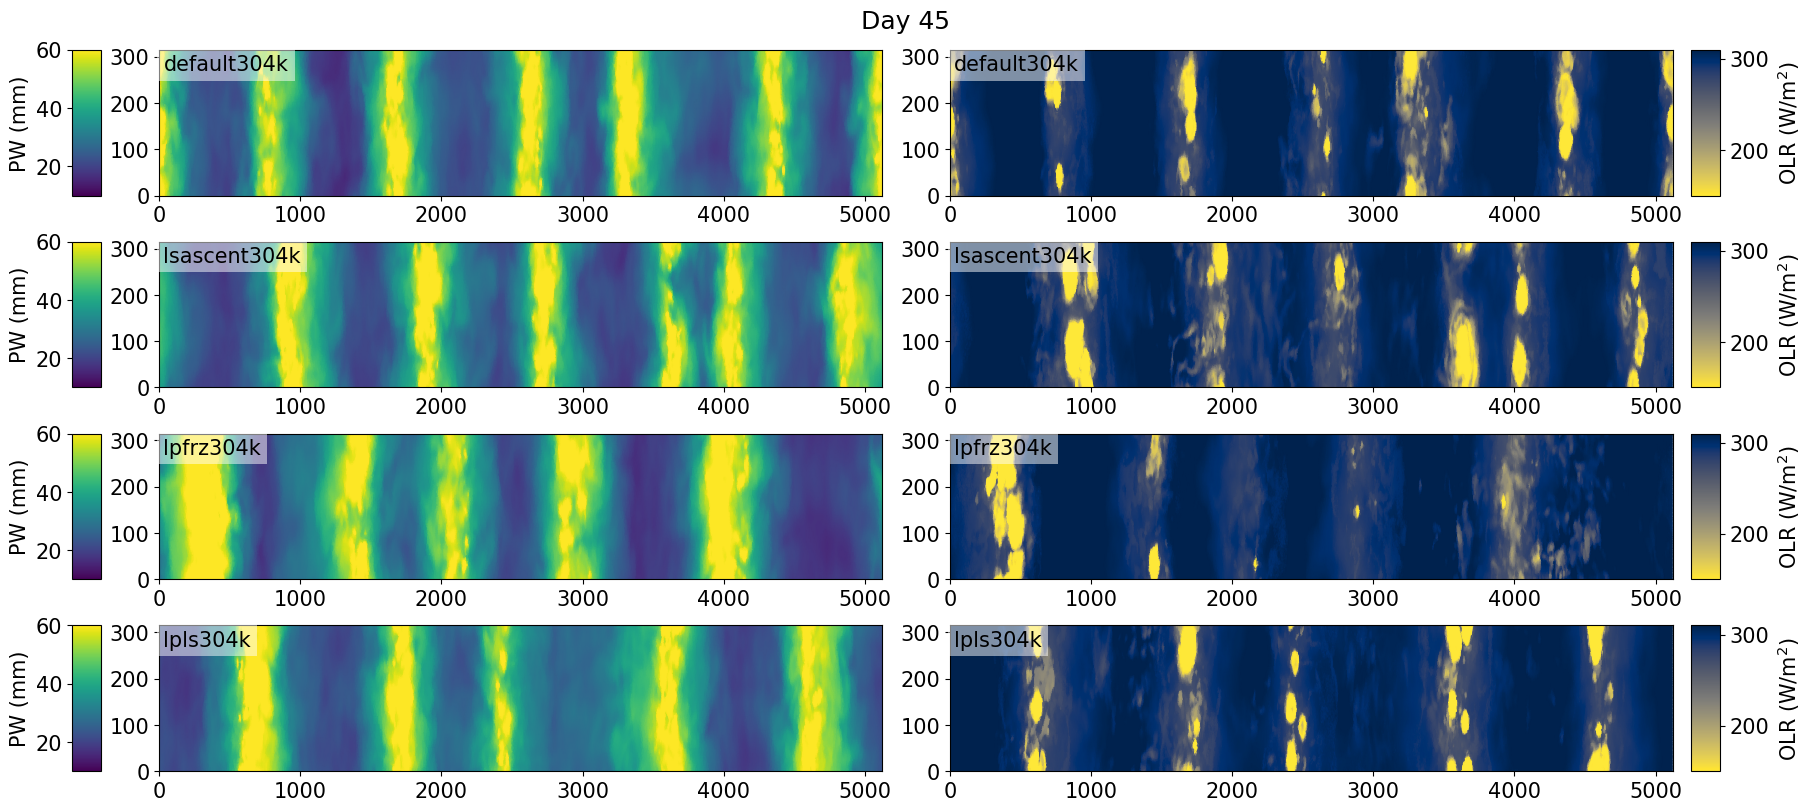

In [42]:
fig = plt.figure(figsize=(18,2*len(runs)), layout='constrained')
gs = GridSpec(len(runs), 4, figure=fig, width_ratios=[4,100,100,4], hspace=0)
savename=""
plt.rcParams['font.size']=15
for i,run in enumerate(runs):
    if run[1] is not None:
        run_name = run[1].split("_")[-2]
    else:
        run_name = run[0][-8:]
    if run[1] is None:
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc"]
    elif run[1].split("_")[-2][:3]=="def":
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-20-03600.nc"]
    elif run[1].split("_")[-2]=="lpfrz304k":
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-10-10800.nc"]
    else:
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-20-10800.nc"]
    ds = xr.open_mfdataset(files)[vars]
    t_snap = ds.time[0].values + timedelta(days=ndays)
    print("RUN:", run_name, "starttime", t_snap)
    ds = ds.sel(time=t_snap, method="nearest")
    print(ds.TMQ.shape)

    x = ds.crm_grid_x/1000
    y = ds.crm_grid_y/1000
    
    cax0 = fig.add_subplot(gs[i,0])
    ax0 = fig.add_subplot(gs[i,1])
    im = ax0.tripcolor(y, x, ds["TMQ"].T,
                       vmin=10, vmax=60,
                       shading="gouraud", cmap="viridis")
    plt.colorbar(im, label="PW (mm)", cax=cax0, shrink=0.8, location="left")
    ax1 = fig.add_subplot(gs[i,2])
    cax1 = fig.add_subplot(gs[i,3])
    im = ax1.tripcolor(y, x, (ds["FLUT"].T),
                       vmin=150, vmax=310,
                       shading="gouraud", cmap="cividis_r")
    plt.colorbar(im, label="OLR (W/m$^2$)", cax=cax1, shrink=0.8)
    ax0.set(xlim=[0,5120], ylim=[0,315],
            xticks=np.arange(0,5120,1000),
            yticks=np.arange(0,320,100))
    ax1.set(xlim=[0,5120], ylim=[0,315],
            xticks=np.arange(0,5120,1000),
            yticks=np.arange(0,320,100))
    ax0.text(30, 305, run_name,
            ha="left", va="top", size=15,
            bbox=dict(boxstyle="square,pad=0.3",
                      fc=(1,1,1,0.5), ec="none"))
    ax1.text(30, 305, run_name,
            ha="left", va="top", size=15,
            bbox=dict(boxstyle="square,pad=0.3",
                      fc=(1,1,1,0.5), ec="none"))
    savename+=run_name
savetime = str(ds.time.values).replace(" ","T")
fig.suptitle("Day "+str(ndays))
plt.savefig(f"../plots/large/OLR_PW_{savename}_{savetime}.pdf")
plt.show()


## 2d vars snapshot - 5 panels

In [16]:
ds = xr.open_dataset(file, chunks={'x':2000})[vars].isel(time=10)  # .isel(time=slice(-120,-1))
ice = xr.open_dataset(file.replace("h1","h0").replace("10800","21600"), chunks={'x':2000})[["IWC","T"]].sel(time=ds.time, method="nearest")
# ice.time[0], ds.time[0], ice.time[1], ds.time[1]


In [29]:
# ndays = 13
for ndays in [59]:
    vars = ["TMQ","FLUT","LHFLX","SHFLX","PRECC","PRECL","TGCLDIWP","crm_grid_x","crm_grid_y"]
    var_units = ["kg/m2","W/m2","W/m2","W/m2","m/s","m/s"]
    if ndays < 50:
        nuc_file = run_dir + run + f"/run/{run}_NUC_hrs.nc"
        bcu_file = run_dir + run + f"/run/{run}_BCU_hrs.nc"
        t3d = 4 * ndays
    else:
        nuc_file = run_dir + run + f"/run/{run}_NUC_hrs.nc"
        bcu_file = run_dir + run + f"/run/{run}_BCU_hrs.nc"
        if run.split("_")[-2]=="lpfrz304k":
            t3d = (ndays-40)*4
        else:
            t3d = (ndays-50)*4
    print(file)
    print(t3d, ndays)
    
    x = ds.crm_grid_x/1000
    y = ds.crm_grid_y/1000
    
    ice = xr.open_dataset(file.replace("h1","h0").replace("10800","21600"), chunks={'x':2000}).isel(time=t3d)[["IWC","T"]]
    ds = xr.open_dataset(file, chunks={'x':2000})[vars].sel(time=ice.time, method="nearest")  # .isel(time=slice(-120,-1))

    print(ice.time.values, ds.time.values)
    # nuc = xr.open_dataset(nuc_file).NUC.isel(time=t3d)#.rename({'x':'ncol'})
    # print(nuc.shape)
    # print(nuc.dims, ice.dims)
    # # nuc = nuc.where((ice['T']<233.15)&(ice['IWC']>=1e-8))
    # nuc = nuc.where((ice['T']<213.15)&(ice['IWC']>=1e-8))
    # print(nuc.shape)
    # bcu = xr.open_dataset(bcu_file).BCU.isel(time=t3d)#.rename({'x':'ncol'})
    # nuc0hrs = nuc.where(bcu<2).mean(dim=['lev'])
    # nuc2hrs = nuc.where((bcu>=2)&(bcu<5)).mean(dim=['lev'])
    # nuc5hrs = nuc.where((bcu>=5)&(bcu<50)).mean(dim=['lev'])
    # nuc50hrs = nuc.where(bcu>=50).mean(dim=['lev'])
    # print(nuc.shape, nuc0hrs.shape, nuc2hrs.shape, nuc5hrs.shape, nuc50hrs.shape)
    
    # do it only 60 at a time to not go over the memory limit
    # for t in range(10,110):  # range(len(olr.time)-2):
    print(t, end="... ")
    fig = plt.figure(figsize=(15,20), layout='constrained')
    gs = GridSpec(7, 2, figure=fig, width_ratios=[100,4], hspace=0)
    ax0 = fig.add_subplot(gs[0,0])
    cax0 = fig.add_subplot(gs[0,1])
    im = ax0.tripcolor(y, x, ds["TMQ"].T,
                       vmin=10, vmax=60,
                       shading="gouraud", cmap="viridis")
    plt.colorbar(im, label="PW (mm)", cax=cax0, shrink=0.8)
    ax1 = fig.add_subplot(gs[1,0])
    cax1 = fig.add_subplot(gs[1,1])
    im = ax1.tripcolor(y, x, (ds["FLUT"].T),
                       vmin=150, vmax=310,
                       shading="gouraud", cmap="cividis_r")
    plt.colorbar(im, label="OLR (W/m$^2$)", cax=cax1, shrink=0.8)
    ax2 = fig.add_subplot(gs[2,0])
    cax2 = fig.add_subplot(gs[2,1])
    im = ax2.tripcolor(y, x, (np.log10(ds["TGCLDIWP"]*1000).T),
                       vmin=-4, vmax=4,
                       shading="gouraud", cmap="YlGnBu_r")
    plt.colorbar(im, label="log10(IWP (g/m$^2$)", cax=cax2, shrink=0.8)
    # ax3 = fig.add_subplot(gs[3,0])
    # cax3 = fig.add_subplot(gs[3,1])
    # im = ax3.tripcolor(y, x, nuc0hrs,
    #                    vmin=0, vmax=6,
    #                    shading="gouraud", cmap="gnuplot")
    # plt.colorbar(im, label="NUC (hrs)",
    #              cax=cax3, shrink=0.8, extend='max')
    # ax4 = fig.add_subplot(gs[4,0])
    # cax4 = fig.add_subplot(gs[4,1])
    # im = ax4.tripcolor(y, x, nuc2hrs,
    #                    vmin=0, vmax=6,
    #                    shading="gouraud", cmap="gnuplot")
    # plt.colorbar(im, label="NUC (hrs)",
    #              cax=cax4, shrink=0.8, extend='max')
    # ax5 = fig.add_subplot(gs[5,0])
    # cax5 = fig.add_subplot(gs[5,1])
    # im = ax5.tripcolor(y, x, nuc5hrs,
    #                    vmin=0, vmax=6,
    #                    shading="gouraud", cmap="gnuplot")
    # plt.colorbar(im, label="NUC (hrs)",
    #              cax=cax5, shrink=0.8, extend='max')
    # ax6 = fig.add_subplot(gs[6,0])
    # cax6 = fig.add_subplot(gs[6,1])
    # im = ax6.tripcolor(y, x, nuc50hrs,
    #                    vmin=0, vmax=6,
    #                    shading="gouraud", cmap="gnuplot")
    # plt.colorbar(im, label="NUC (hrs)",
    #              cax=cax6, shrink=0.8, extend='max')
    
    ax0.set(ylabel="PW\nkm", xlim=[0,5120], ylim=[0,320])
    ax1.set(ylabel="OLR\nkm", xlim=[0,5120], ylim=[0,320])
    ax2.set(ylabel="IWP\nkm", xlim=[0,5120], ylim=[0,320])
    # ax3.set(ylabel="$\{tau}_{conv}<2$\nkm", xlim=[0,5120], ylim=[0,320])
    # ax4.set(ylabel="$2\leq \{tau}_{conv}<5$\nkm", xlim=[0,5120], ylim=[0,320])
    # ax5.set(ylabel="$5\leq \{tau}_{conv}<50$\nkm", xlim=[0,5120], ylim=[0,320])
    # ax6.set(ylabel="$\{tau}_{conv}>50$\nkm",xlabel="km",
    #         xlim=[0,5120], ylim=[0,320])
    fig.suptitle(f"{ds.time.values}")
    savetime=(str(ice.time.values).replace(" ","T").split(":")[0])
    savename=f"../plots/large/vars2d_cirrustemps_{run}_{(savetime)}.png"
    plt.savefig(savename)
    print("saved as "+savename)
    plt.close()

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_lsascent300k_branch/run/dpscream_rce_large_3km_lsascent300k_branch.eam.h1.2000-02-20-10800.nc
36 59
2000-03-01 06:00:00 2000-03-01 06:00:00
[########################################] | 100% Completed | 102.14 ms
[########################################] | 100% Completed | 104.77 ms
[########################################] | 100% Completed | 102.68 ms
[########################################] | 100% Completed | 121.06 ms
[########################################] | 100% Completed | 103.30 ms
[########################################] | 100% Completed | 118.47 ms
[########################################] | 100% Completed | 103.34 ms
[########################################] | 100% Completed | 104.60 ms
[########################################] | 100% Completed | 103.23 ms
[########################################] | 100% Completed | 104.92 ms
[########################################] | 100% Completed |

In [ ]:

# # do it only 60 at a time to not go over the memory limit
# # for t in range(17,110):  # range(len(olr.time)-2):
# print(t, end="... ")
# fig = plt.figure(figsize=(15,20), layout='constrained')
# gs = GridSpec(6, 2, figure=fig, width_ratios=[100,4], hspace=0)
# ax0 = fig.add_subplot(gs[0,0])
# cax0 = fig.add_subplot(gs[0,1])
# im = ax0.tripcolor(y, x, ds["TMQ"].T,
#                    vmin=10, vmax=60,
#                    shading="gouraud", cmap="viridis")
# plt.colorbar(im, label="PW (mm)", cax=cax0, shrink=0.8)
# ax1 = fig.add_subplot(gs[1,0])
# cax1 = fig.add_subplot(gs[1,1])
# im = ax1.tripcolor(y, x, (ds["FLUT"].T),
#                    vmin=150, vmax=310,
#                    shading="gouraud", cmap="viridis")
# plt.colorbar(im, label="FLUT (W/m2)", cax=cax1, shrink=0.8)
# ax2 = fig.add_subplot(gs[2,0])
# cax2 = fig.add_subplot(gs[2,1])
# im = ax2.tripcolor(y, x, ((ds["LHFLX"]+ds["SHFLX"]).T),
#                    vmin=60, vmax=140,
#                    shading="gouraud", cmap="viridis")
# plt.colorbar(im, label="THF (W/m2)", cax=cax2, shrink=0.8)
# ax3 = fig.add_subplot(gs[3,0])
# cax3 = fig.add_subplot(gs[3,1])
# im = ax3.tripcolor(y, x, ((ds["PRECC"]+ds["PRECL"]).T)*(3600*24*1000),
#                    vmin=60, vmax=100,
#                    shading="gouraud", cmap="viridis")
# plt.colorbar(im, label="PREC (mm/day)", cax=cax3, shrink=0.8)
# ax4 = fig.add_subplot(gs[4,0])
# cax4 = fig.add_subplot(gs[4,1])
# im = ax4.tripcolor(y, x, (np.log10(ds["TGCLDIWP"]*1000).T),
#                    vmin=-4, vmax=4,
#                    shading="gouraud", cmap="viridis")
# plt.colorbar(im, label="log10(IWP (g/m3))", cax=cax4, shrink=0.8)
# ax5 = fig.add_subplot(gs[5,0])
# cax5 = fig.add_subplot(gs[5,1])
# im = ax5.tripcolor(y, x, nuc,
#                    vmin=0, vmax=12,
#                    shading="gouraud", cmap="terrain")
# plt.colorbar(im, label="NUC > BCU (T<-40$^\circ$C & cldy)",
#              cax=cax5, shrink=0.8, extend='max')

# ax0.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
# ax1.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
# ax2.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
# ax3.set(ylabel="km", xlim=[0,5120], ylim=[0,320])
# ax4.set(xlabel="km", xlim=[0,5120], ylim=[0,320])
# ax5.set(xlabel="km",ylabel="km",
#         xlim=[0,5120], ylim=[0,320])
# fig.suptitle(f"{ds.time.values}")
# savename=f"../plots/large/vars2d_pw_olr_prec_thf_iwp_nuc_t{t:03d}.png"
# plt.savefig(savename)
# print("saved as "+savename)
# plt.show()


## mean OLR vs SWU and LW vs SW CRE values

In [4]:
runs = [["dpscream_rce_large_3km_aa_default","dpscream_rce_large_3km_default300k_branch"],
        ["dpscream_rce_large_3km_aa_304ksst","dpscream_rce_large_3km_default304k_branch"],
        ["dpscream_rce_large_3km_ab_lsascent", "dpscream_rce_large_3km_lsascent300k_branch"],
        ["dpscream_rce_large_3km_aa_lsascent_304ksst","dpscream_rce_large_3km_lsascent304k_branch"],
        ["dpscream_rce_large_3km_aa_lpfrz", "dpscream_rce_large_3km_lpfrz300k_branch"],
        ["dpscream_rce_large_3km_aa_lpfrz304k", "dpscream_rce_large_3km_lpfrz304k_branch"],
        ["dpscream_rce_large_3km_lpls300k", None],
        ["dpscream_rce_large_3km_lpls304k", None]]
markers=["D","D","X","X","s","s","o","o"]
colors = ["gray","tab:red","darkviolet","tab:purple","lightblue","tab:blue","gold","goldenrod"]
# markers = dict(zip(runs,markers_list))
run_dir="/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/"

In [5]:
ndays=20
olrs = {}
swus = {}
lcfs = {}  # longwave cloud forcing
scfs = {}  # shortwave cloud forcing

In [6]:
vars=['FLUT','FSUTOA']
vars=['LWCF','SWCF']
vars=['FLUT','FSUTOA','LWCF','SWCF']
for run in runs:
    if run[1] is not None:
        run_name = run[1].split("_")[-2]
    else:
        run_name = run[0][-8:]
    if run[1] is None:
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc"]
    elif run[1].split("_")[-2][:3]=="def":
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-20-03600.nc"]
    elif run[1].split("_")[-2]=="lpfrz304k":
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-10-10800.nc"]
    else:
        files = [run_dir+f"{run[0]}/run/{run[0]}.eam.h1.2000-01-01-00000.nc",
                 run_dir+f"{run[1]}/run/{run[1]}.eam.h1.2000-02-20-10800.nc"]
    ds = xr.open_mfdataset(files)[vars]
    ds_starttime = ds.time[-1].values - timedelta(days=ndays)
    print("RUN:", run_name, "starttime", ds_starttime)
    iday = np.argmin(abs(ds.time.values-ds_starttime))
    assert(ds_starttime==ds.time[iday])
    ds = ds.isel(time=slice(iday,-1)).mean(dim=['ncol','time'])
    olrs[run_name]=ds[vars[0]].values
    swus[run_name]=ds[vars[1]].values
    lcfs[run_name]=ds[vars[2]].values
    scfs[run_name]=ds[vars[3]].values
    print("\t", olrs[run_name], "W/m2", swus[run_name], "W/m2")

RUN: default300k starttime 2000-02-10 00:00:00
[########################################] | 100% Completed | 2.46 sms
[########################################] | 100% Completed | 2.27 ss
[########################################] | 100% Completed | 1.95 sms
[########################################] | 100% Completed | 2.07 sms
	 276.84836 W/m2 66.1561 W/m2
RUN: default304k starttime 2000-02-09 23:00:00
[########################################] | 100% Completed | 2.34 ss
[########################################] | 100% Completed | 2.44 ss
[########################################] | 100% Completed | 2.48 ss
[########################################] | 100% Completed | 2.05 sms
	 287.90256 W/m2 64.43382 W/m2
RUN: lsascent300k starttime 2000-02-10 00:00:00
[########################################] | 100% Completed | 1.73 sms
[########################################] | 100% Completed | 2.54 sms
[########################################] | 100% Completed | 1.85 sms
[###################

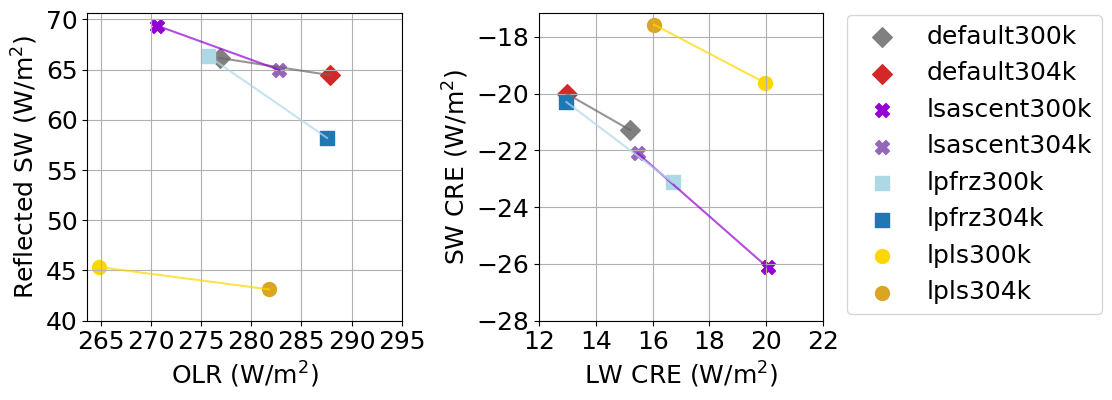

In [13]:
fig, ax = plt.subplots(1,2,figsize=(11,4))  # ,layout="constrained")

for i,run in enumerate(runs):
    if run[1] is not None:
        run_name = run[1].split("_")[-2]
    else:
        run_name = run[0][-8:]
    ax[0].scatter(olrs[run_name],
               swus[run_name],
               marker=markers[i],
               color=colors[i],
               label=run_name,
               s=100
              )
    ax[1].scatter(lcfs[run_name],
               scfs[run_name],
               marker=markers[i],
               color=colors[i],
               s=100
              )
for r in ["default", "lsascent", "lpfrz", "lpls"]:
    ax[0].plot([olrs[f"{r}300k"],
             olrs[f"{r}304k"]],
            [swus[f"{r}300k"],
             swus[f"{r}304k"]],
        color=util.get_run_color(r),
        alpha=0.7)
    ax[1].plot([lcfs[f"{r}300k"],
             lcfs[f"{r}304k"]],
            [scfs[f"{r}300k"],
             scfs[f"{r}304k"]],
        color=util.get_run_color(r),
        alpha=0.7)

ax[0].grid(True)
ax[1].grid(True)
ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')
plt.subplots_adjust(wspace=0.05)
fig.legend(loc="center left", bbox_to_anchor=(0.85,0.5))
ax[0].set(xlabel="OLR (W/m$^2$)", ylabel="Reflected SW (W/m$^2$)",
       # xlim=[265,295], ylim=[57,71],
         yticks=np.arange(40,71,5), xticks=np.arange(265,296,5))
ax[1].set(xlabel="LW CRE (W/m$^2$)", ylabel="SW CRE (W/m$^2$)",
           # xlim=[12,22], ylim=[-28,-18],
         xticks=np.arange(12,23,2), yticks=np.arange(-28,-17,2))
plt.savefig("../plots/large/mean_LWvSWallsky-cre_all.pdf", bbox_inches="tight", pad_inches=0.5)
plt.show()